# Time-series inversion of disconnected networks

When parts of a network become disconnected (no correlation pairs between a group of dates to the others), the matrix system cannot be properly solved, resulting in severe artifacts in the inverted cumulative time-series. In this notebook, we will inverstigate this behavior using a synthetic displacement signal and also explore ways to indirectly connect the network to resolve artifacts.  

In [1]:
# load neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from itertools import combinations
import random

#import functions for time-series inversion from relevant python script
import timeseries_inversion as inv

In [2]:
#create an artificial displacement original_signal (analog to previous notebook)
start_date = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_date = datetime.strptime('31/12/2023', '%d/%m/%Y')

dr = pd.date_range(start=start_date, end=end_date, freq='D')

#create synthetic cumulative displacement signal
#here: sigmoid + linear function
x = np.arange(0, len(dr), 1)
y = 0.01 * x + 20 / (1 + np.exp(-0.02 * (np.arange(len(dr)) - len(dr)/2)))
original_signal = pd.DataFrame({'date': dr.date, 'disp': y})

#create sample dates, here with a 3 month spacing
sample_dates = pd.date_range(start=start_date, end=end_date, freq='3MS').date

#create image pairs from sample dates
date_combinations = list(combinations(sample_dates, 2))

network = pd.DataFrame(date_combinations, columns=['date0', 'date1'])

#find displacement for each datepair according to the synthetic signal
network['disp'] = network.apply(lambda row: inv.find_dsoll(row, original_signal), axis = 1)

In [3]:
#disconnect the network. here, I am only keeping connections for date pairs from a similar season

dt = (network.date1 - network.date0).dt.days
dt_rad_year = (dt / 365.25) * ( np.pi)

#select days with less than +/- 15 day seasonal difference 
disconnected_network = network.loc[abs(np.sin(dt_rad_year)) <= (15 / 365.25) * ( np.pi)] 

When running the inversion for the disconnected network, the inverted time-series will contain artifacts:

Number of image pairs: 40
Number of disconnected components in network: 3 
	The network appears to be disconnected. Consider connecting it to avoid artifacts.


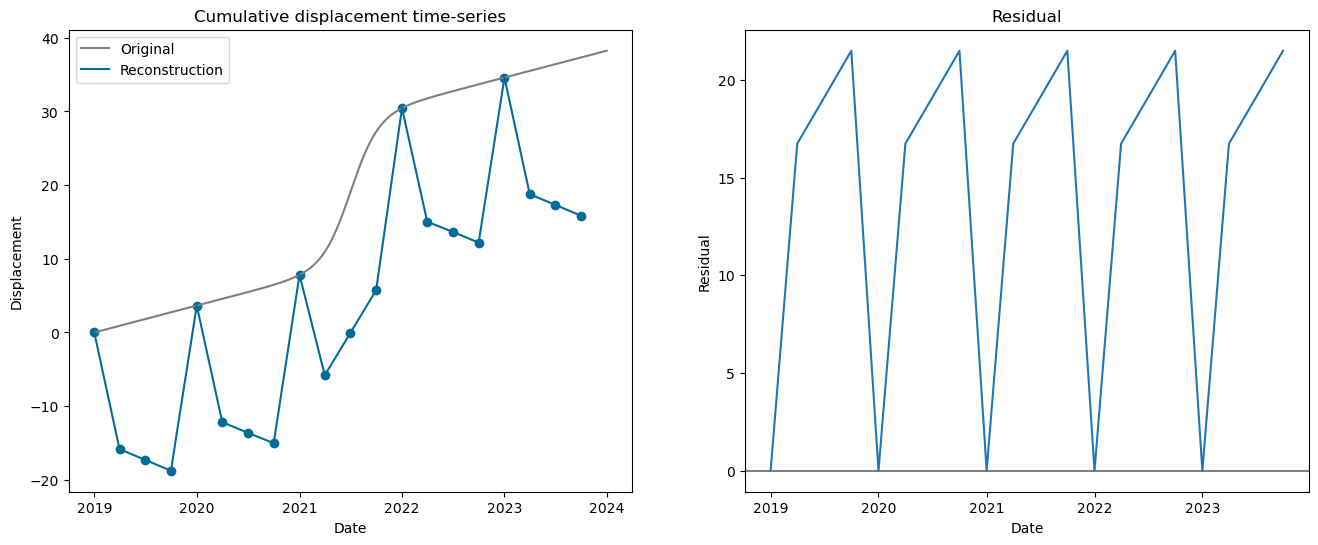

In [4]:
timeseries = inv.run_inversion(disconnected_network)
inv.plot_results(timeseries, original_signal)

## Adding indirect connections

To connect isolated network components, we suggest to artificially link the network by adding indirect links. Displacement measures at these links are based on linear interpolation of existing direct links. The number of added links will influence the appearance of the inverted time-series. Adding many indirect connections generally results in a smoother time-series but may also smooth over non-linear potions. Fewer indirect connections allow to better preserve the original measurements, however, noise in the network can propagate to the inverted time-series more easily.

Number of image pairs: 184
Number of disconnected components in network: 0 


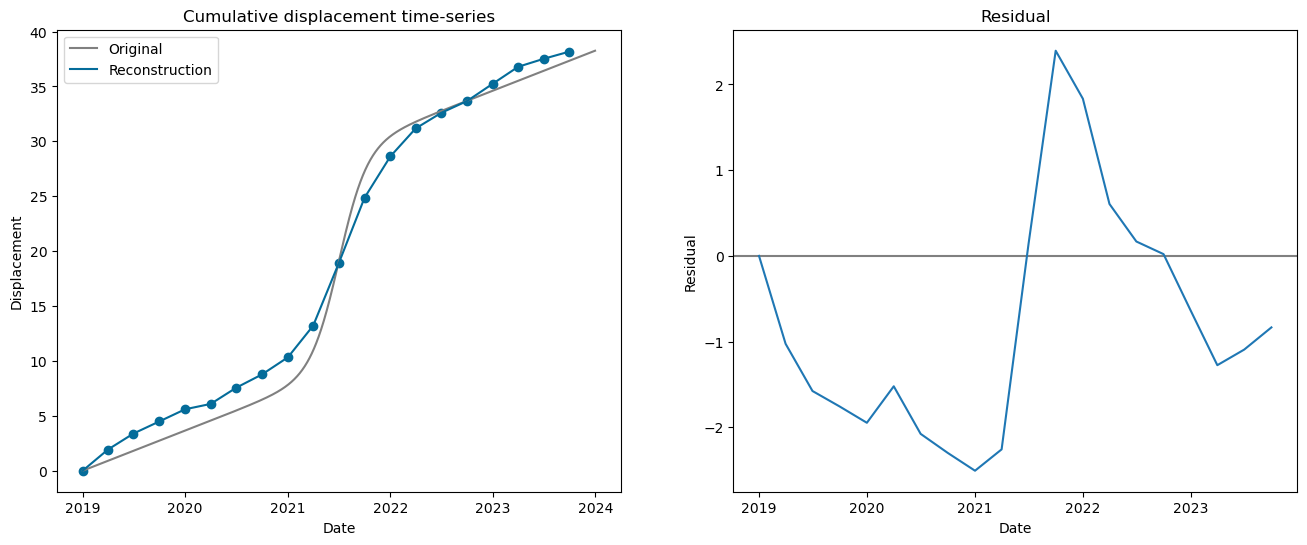

In [5]:
#add the maximum number of possible indirect connections
#use the disconnected network and a network that contains all possible connections
connected_network1 = inv.find_indirect(disconnected_network, network) 

timeseries = inv.run_inversion(connected_network1)
inv.plot_results(timeseries, original_signal)

Number of image pairs: 43
Number of disconnected components in network: 0 


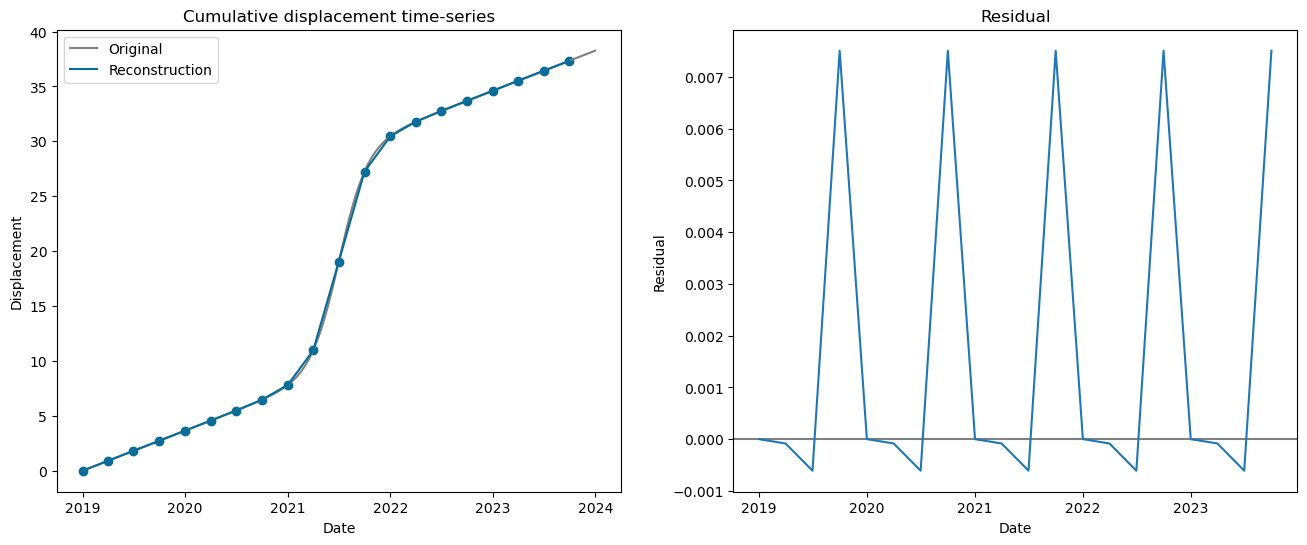

In [6]:
#add the minimum number of indirect connections. preference will be given to short and low displacement links
connected_network2 = inv.find_indirect_minimum(disconnected_network) 

timeseries = inv.run_inversion(connected_network2)
inv.plot_results(timeseries, original_signal)

While under noise-free conditions, the minimum number option performs considerably better, the addition of noise reduces the reconstruction accuracy:

Number of image pairs: 43
Number of disconnected components in network: 0 


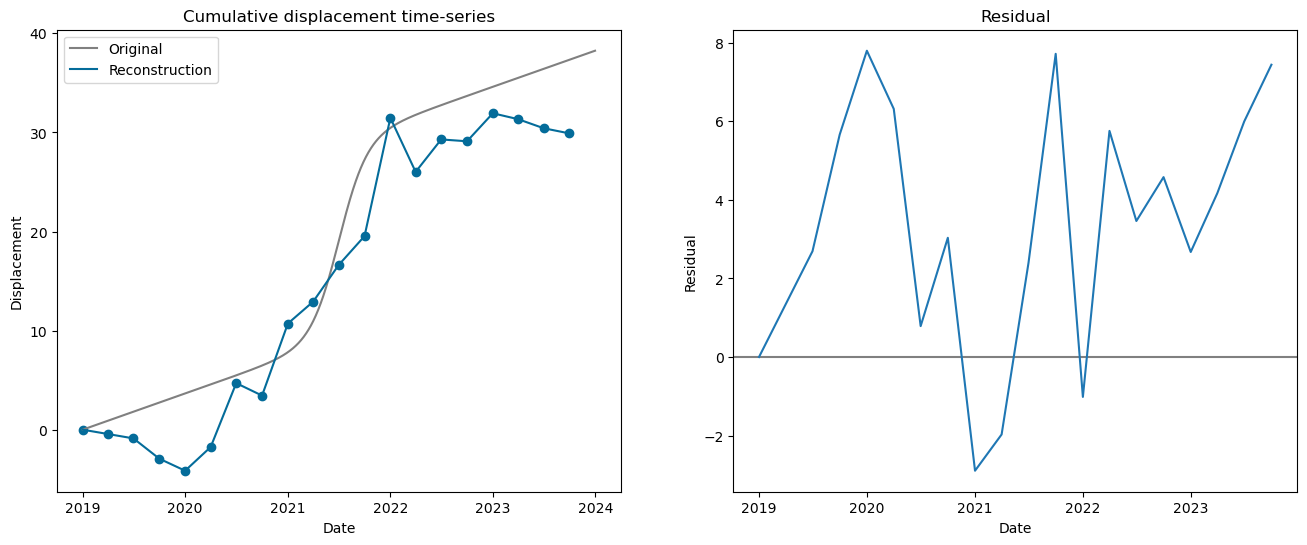

In [7]:
#add Gaussian noise to original displacement signal
np.random.seed(123)
noise = np.random.normal(0,5,len(disconnected_network))
disconnected_network = disconnected_network.assign(disp=disconnected_network.disp + noise)

connected_network3 = inv.find_indirect_minimum(disconnected_network) 

timeseries = inv.run_inversion(connected_network3)
inv.plot_results(timeseries, original_signal)

Here, the smoothing capabilities of the large number of connections can be benificial:

Number of image pairs: 184
Number of disconnected components in network: 0 


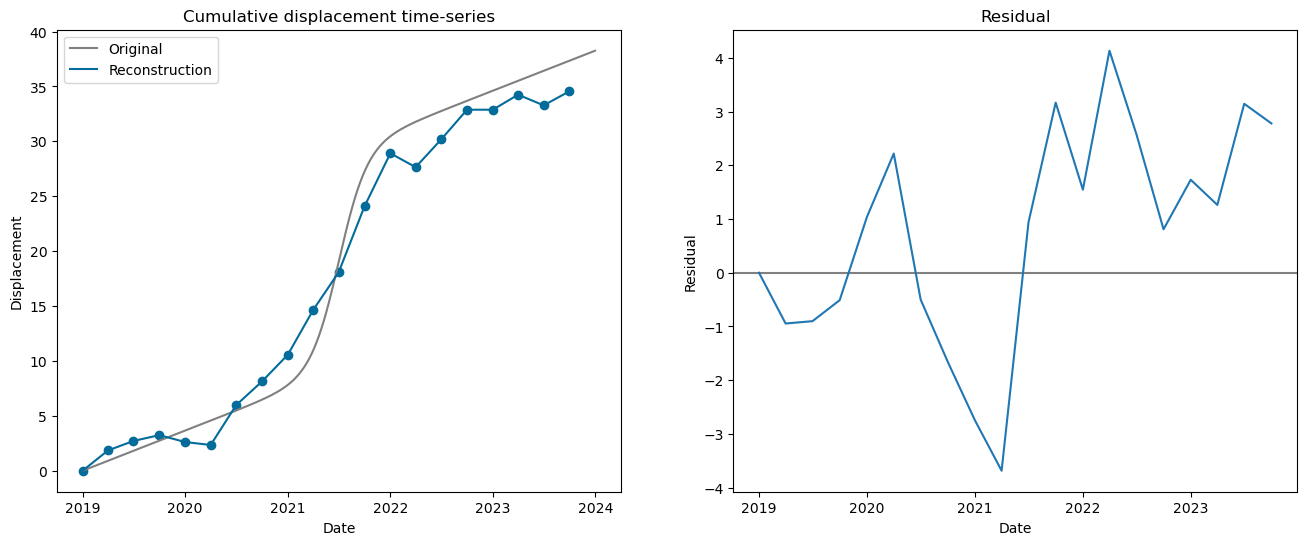

In [8]:
connected_network4 = inv.find_indirect(disconnected_network, network) 

timeseries = inv.run_inversion(connected_network4)
inv.plot_results(timeseries, original_signal)

A compromise between both methods is to set a maximum time difference limit, which limits the how much longer the temporal baseline of a reference connection may be. If a reference connection is much longer than the indirect link for which displacement is interpolated, the resulting value has a higher change to not reflect the actual signal. Here is an example for limiting the temporal baseline to a maximum difference of half a year:

Number of image pairs: 107
Number of disconnected components in network: 0 


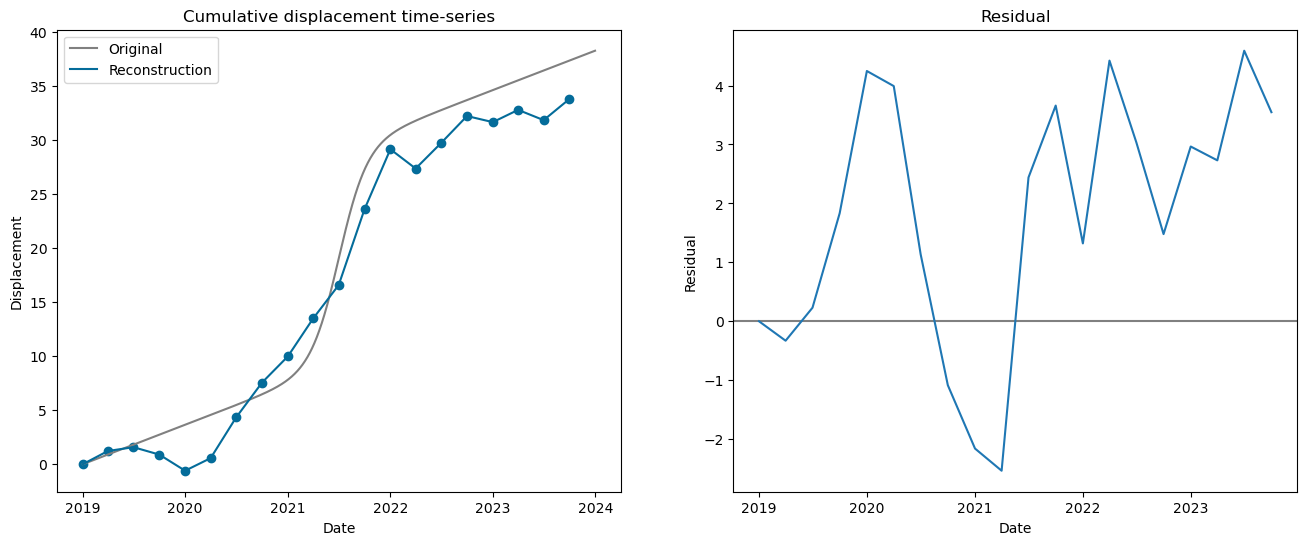

In [9]:
connected_network5 = inv.find_indirect(disconnected_network, network, max_day_diff = 182) 

timeseries = inv.run_inversion(connected_network5)
inv.plot_results(timeseries, original_signal)

In [10]:
#save for plotting in R - see Rplotting folder for examples

connected_network5.to_csv("./Rplotting/network_example.csv", index = False)
timeseries.to_csv("./Rplotting/timeseries_example.csv", index = False)